# Introduction

For this challenge/competition/assignment, we will be working with the [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data) dataset. The ultimate goal is to predict whether or not a given Tweet indicates that an emergency or disaster is in progress or imminent. This type of prediction ability can be generally useful for emergency services to have early detection of events that may require their attention. Beyond using Twitter as a source, news outlets and social media streams could be integrated for a more broad coverage of potential disasters.

Overall, this challenge requires the use of NLP (Natural Language Processing) to classify a Tweet as either indicating a disaster or not.

We'll first look at the general size, dimensions, and strucutre of the provided datasets.

In [1]:
# Imports.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
global_random_seed=42

random.seed(global_random_seed)
np.random.seed(global_random_seed)

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/bert/keras/bert_small_en_uncased/2/config.json
/kaggle/input/bert/keras/bert_small_en_uncased/2/tokenizer.json
/kaggle/input/bert/keras/bert_small_en_uncased/2/metadata.json
/kaggle/input/bert/keras/bert_small_en_uncased/2/model.weights.h5
/kaggle/input/bert/keras/bert_small_en_uncased/2/assets/tokenizer/vocabulary.txt
/kaggle/input/bert/keras/bert_tiny_en_uncased/2/config.json
/kaggle/input/bert/keras/bert_tiny_en_uncased/2/tokenizer.json
/kaggle/input/bert/keras/bert_tiny_en_uncased/2/metadata.json
/kaggle/input/bert/keras/bert_tiny_en_uncased/2/model.weights.h5
/kaggle/input/bert/keras/bert_tiny_en_uncased/2/assets/tokenizer/vocabulary.txt


In [2]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [3]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


The training dataset consists of the following columns: `id`, `keyword`, `location`, `text`, and `target`. From the provided dataset description, we have the following definitions:

* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

`keyword`, `location`, and `text` are the likely input features that we'll explore below.

7613 samples are provided in the training dataset.

In [4]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


Similarly, as expected, the test dataset consists of the same columns minus `target`. There are 3263 samples in the test dataset.

# Exploratory Data Analysis (EDA) and Cleaning

We will now perform some EDA on the datasets in order to have a better idea of what we're working with and to help guide later decisions for model architecture. Additionally, we will perform any data cleaning that may be necessary based on our data exploration.

## EDA

As discovered in the Introduction, the `text`, `location`, and `keyword` columns are possible input features. The data description indicated that `location` and `keyword` may be blank, so we should first determine whether enough of these fields are non-null to be useful for training and inference, and whether the data quality is useful or not:

In [5]:
target_cols = ['keyword','location']

print("Missing Value Percentages:\n")
for dfn, df in [('Training', train_df), ('Test', test_df)]:
    null_ratio = df[target_cols].isnull().sum() / df.shape[0]
    print(f"{dfn} Dataset:")
    for col, ratio in null_ratio.items():
        print(f"  {col:<10}: {ratio:.2%}")
    print()

Missing Value Percentages:

Training Dataset:
  keyword   : 0.80%
  location  : 33.27%

Test Dataset:
  keyword   : 0.80%
  location  : 33.86%



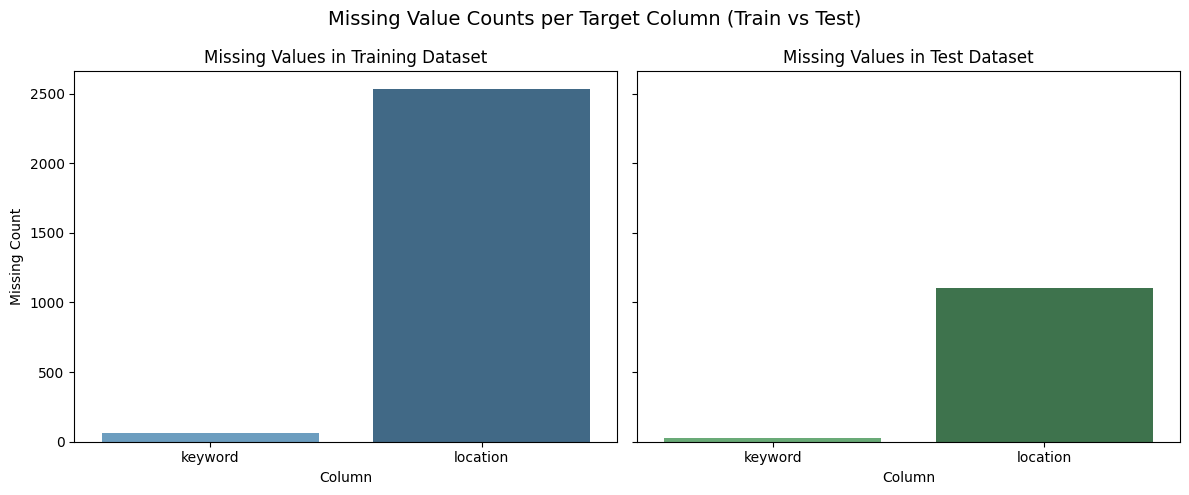

In [6]:
train_missing = train_df[target_cols].isnull().sum()
test_missing = test_df[target_cols].isnull().sum()

missing_df = pd.DataFrame({
    'Train': train_missing,
    'Test': test_missing
}).reset_index().rename(columns={'index': 'Column'})

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.barplot(data=missing_df, x='Column', y='Train', ax=axes[0], palette='Blues_d')
axes[0].set_title('Missing Values in Training Dataset')
axes[0].set_ylabel('Missing Count')
axes[0].set_xlabel('Column')

sns.barplot(data=missing_df, x='Column', y='Test', ax=axes[1], palette='Greens_d')
axes[1].set_title('Missing Values in Test Dataset')
axes[1].set_ylabel('')
axes[1].set_xlabel('Column')

plt.suptitle('Missing Value Counts per Target Column (Train vs Test)', fontsize=14)
plt.tight_layout()
plt.show()

There are very few `keyword` values missing, but there is about 1/3 of the `location` values missing. We can take a look at the top `location` values used to see if they're somewhat normalized, which *might* make it worth while to fill NaN values.

In [7]:
top_n = 20
location_counts = train_df['location'].value_counts(dropna=True).head(top_n)

print(f"Top {top_n} Most Frequent Locations:\n")
print(location_counts)

Top 20 Most Frequent Locations:

location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Chicago, IL         18
Australia           18
California          17
California, USA     15
New York, NY        15
Everywhere          15
San Francisco       14
Name: count, dtype: int64


These values appear to indicate that `location` is likely free-form, so the column is generally not very clean and we will remove it during _Data Cleaning_.

Although we won't do it here, one option could be to try to normalize the existing location data to make it potentially more useful. However, in a real-world scenario, this could cause issues at inference time if the `location` values continued to be free-form and we don't want to normalize on the fly.

We will now look at the `keyword` column from a similar angle to determine the viability of the data as a training input.

Instead of looking at top unique values, we'll take a slightly different approach and look at the ratio of unique values.

In [8]:
def calculate_uniqueness_ratio(df, column_name):
    non_null_data = df[column_name].dropna()
    num_unique = non_null_data.nunique()
    total_non_null = non_null_data.shape[0]
    unique_ratio = num_unique / total_non_null
    return num_unique, total_non_null, unique_ratio

train_unique, train_total, train_unique_ratio = calculate_uniqueness_ratio(train_df, 'keyword')
test_unique, test_total, test_unique_ratio = calculate_uniqueness_ratio(test_df, 'keyword')

print(f"Training Dataset - 'keyword' column:")
print(f"   Total non-null: {train_total}")
print(f"   Unique keyword values: {train_unique}")
print(f"   Unique ratio: {train_unique_ratio:.2%}\n")

print(f"Test Dataset - 'keyword' column:")
print(f"   Total non-null: {test_total}")
print(f"   Unique keyword values: {test_unique}")
print(f"   Unique ratio: {test_unique_ratio:.2%}")

Training Dataset - 'keyword' column:
   Total non-null: 7552
   Unique keyword values: 221
   Unique ratio: 2.93%

Test Dataset - 'keyword' column:
   Total non-null: 3237
   Unique keyword values: 221
   Unique ratio: 6.83%


The ratio is fairly low for both the training and test datasets, which indicate that the values are relatively uniform and will probably provide good input for a training feature. We will of course still want to fill NaN values with something like `unknown` to help embedding layers during training.

Finally, we'll get a sense of the length of Tweets via a histogram visualization.

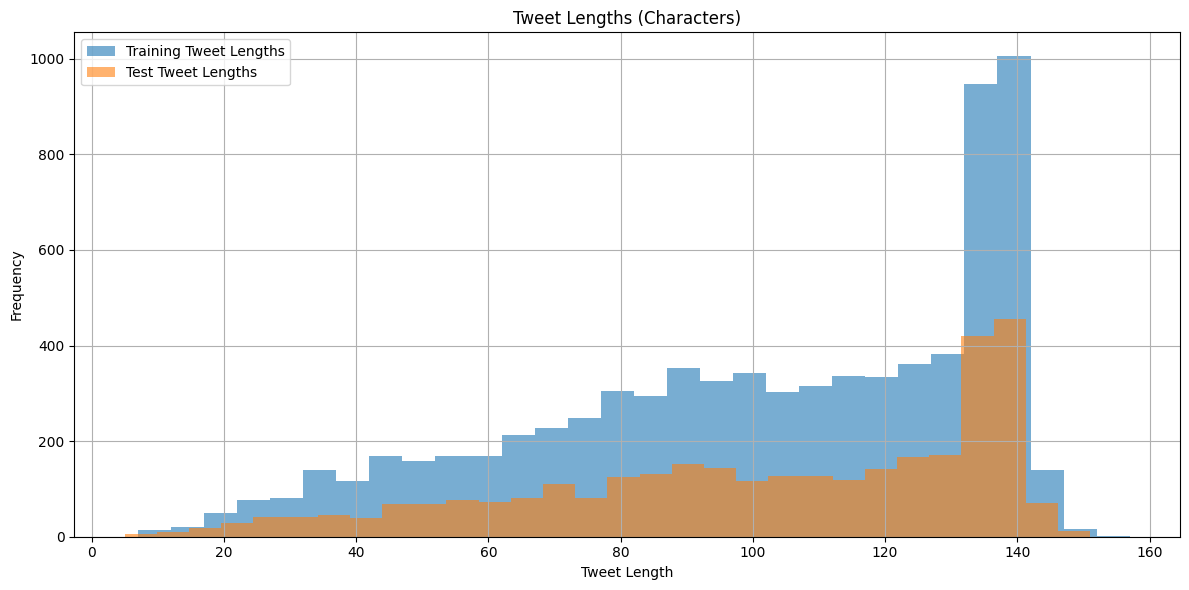

In [9]:
plt.figure(figsize=(12, 6))

plt.hist(train_df['text'].apply(len), bins=30, alpha=0.6, label='Training Tweet Lengths')
plt.hist(test_df['text'].apply(len), bins=30, alpha=0.6, label='Test Tweet Lengths')

plt.title('Tweet Lengths (Characters)')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

As expected, the length of Tweets mave a maximum below 160 characters since that is the original max length of SMS messages. There aren't any major outliers, and the general distribution shape between the training and test datasets are relatively uniform, so we won't perform any explicit cleaning of the `text` column. Future iterations could potentially clean the raw text with steps like separating words from punctuation and special characters to improve embedding signals.

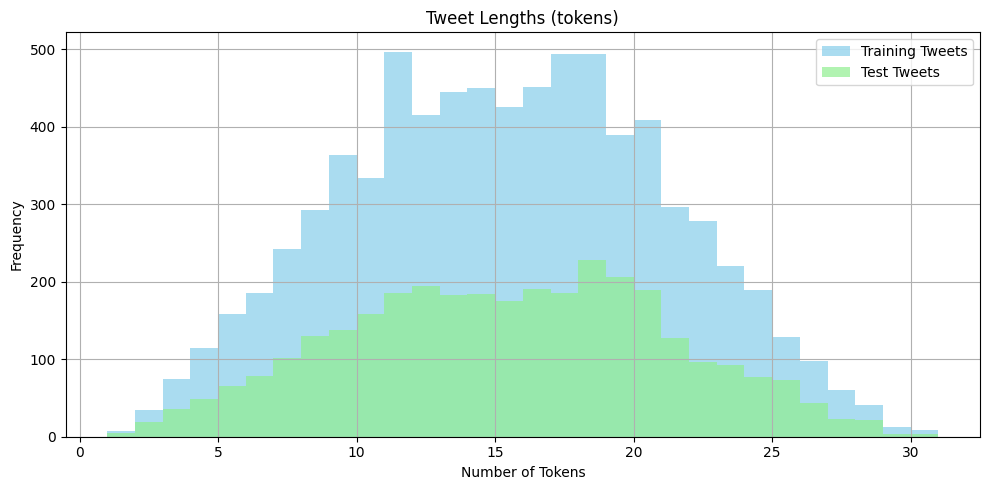

In [10]:
plt.figure(figsize=(10, 5))
plt.hist(train_df['text'].apply(lambda x: len(x.split())), bins=30, alpha=0.7, color='skyblue', label='Training Tweets')
plt.hist(test_df['text'].apply(lambda x: len(x.split())), bins=30, alpha=0.7, color='lightgreen', label='Test Tweets')
plt.title('Tweet Lengths (tokens)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Finally, above we can see the distribution of Tweet lengths by number of tokens ("words" split by spaces). The Tweets are generally fairly short, so we should take that into consideration when choosing the initial model architecture (e.g., could use 32 or 64 for the word encoding output/embedding layer input).

## Data Cleaning

Based on the above EDA, we'll perform the following data cleaning:

* Remove the `location` column
* Fill `NaN`s in the `keyword` column

In [11]:
# drop the "location" column from both datasets.
train_df = train_df.drop(columns=['location'])
test_df = test_df.drop(columns=['location'])

# fill the keyword column with "no_keyword" for any NaN values.
train_df['keyword'] = train_df['keyword'].fillna('no_keyword')
test_df['keyword'] = test_df['keyword'].fillna('no_keyword')

## Data Augmentation

We don't want to lose the potential signal from the `keyword` column, so we'll append the values to the existing text, making it part of the overall input stream for a Tweet.

In [12]:
train_df['text'] = train_df['text'] + ' ' + train_df['keyword']
test_df['text'] = test_df['text'] + ' ' + test_df['keyword']

# Model Architecture and Training

In this section we will describe the initial model architecture, perform model training, and score the results for the initial model.

After baseline model training and scoring, we will perform hyperparameter tuning and comparison with different model architectures/types.

## GRU Model #1

During EDA we determined that the Tweet lengths in "words" was almost always shorter than 30, and mostly centered around 15 for both the training and test data. In order to try to capture the semantic meaning of various words in the Tweets, we'd like to use an architecture that has "memory" through the sequence tokens. Two very common architectures that provide this feature are LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit).

Given the small token count, we will start with using a `GRU` layer for classification since it does not need long range memory. A GRU should result in a smaller model that we can train faster due to the slightly simpler architecture (one less gate, and combined cell/hidden state).

As we know, models can't be trained with raw text, so we need to encode the text tokens as numbers. For this step, we'll use the Keras [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer. It will standardize strings, build a vocabulary with our training data, and basically provide a mapping from text tokens to a representative integer index. When a string is fed through the vectorizer, it will return a vector of integers representation of that string for use in model training and inference. Tweets shorter than the max token size we specify will be padded.

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, TextVectorization
from sklearn.model_selection import train_test_split

tf.random.set_seed(global_random_seed)

2025-08-13 13:33:40.064662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755092020.258749      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755092020.329554      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
# Set up the TextVectorization layer for our training data. Use output_sequence_length based on our knowledge
# of max Tweet token length. Choose a relatively large max vocab size of 10000.
vocab_size = 10000
max_tweet_tokens = 35
vectorizer = TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=max_tweet_tokens,
    output_mode="int"
)
vectorizer.adapt(train_df['text'].values)

I0000 00:00:1755092032.102203      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


We can now see how the vectorizer has encoded a sample Tweet. Note that a trailing padding of zeros has been applied to the returned vector, text has been lower-cased, and special characters removed. We also have an `[UNK]` token, indicating that `pours` is not in the vectorizer's vocabulary.

In [15]:
sample_tweet = train_df['text'][4]
print(sample_tweet)
print()
print(vectorizer(sample_tweet))
print()
tmp_vocab = vectorizer.get_vocabulary()
reconstructed_string = ' '.join([tmp_vocab[i] for i in vectorizer(sample_tweet)])
print(reconstructed_string)

Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school  no_keyword

tf.Tensor(
[  29   99 1232   19  463   20 9594 2401   26  165   20 1391    1   69
    3  295  329    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0], shape=(35,), dtype=int64)

just got sent this photo from ruby alaska as smoke from wildfires [UNK] into a school nokeyword                  


Now to build and train the GRU model.

We'll use a basic architecture around the GRU layer:
* Vectorizer consumes text and feeds fixed-length vectors into the Embedding layer, which builds the word embeddings during training.
* Embeddings feed into the GRU layer, starting with a round number of 64 units.
* GRU output is fed through a 50% Dropout layer to try to help avoid some overfitting.
* Dropout feeds into a fully-connected (Dense) layer with ReLU activation, then to the final single-unit Dense layer with signmoid activation for binary classification.

In [16]:
texts = train_df["text"].values
labels = train_df["target"].values

# Split training data into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Initial model is a GRU using our TextVectorization to feed through an Embedding layer before the GRU layer.
model = Sequential([
    vectorizer,
    Embedding(input_dim=vocab_size, output_dim=64),
    GRU(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [17]:
# %%time
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10


I0000 00:00:1755092038.087886      56 cuda_dnn.cc:529] Loaded cuDNN version 90300


191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5480 - loss: 0.6886 - val_accuracy: 0.5739 - val_loss: 0.6847
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5637 - loss: 0.6872 - val_accuracy: 0.5739 - val_loss: 0.6835
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5636 - loss: 0.6873 - val_accuracy: 0.5739 - val_loss: 0.6841
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6379 - loss: 0.6152 - val_accuracy: 0.7997 - val_loss: 0.4440
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8532 - loss: 0.3653 - val_accuracy: 0.7965 - val_loss: 0.5084
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9096 - loss: 0.2461 - val_accuracy: 0.7814 - val_loss: 0.5813
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9385 - loss: 0.1705 - val_accuracy: 0.7761 - val_loss: 0.7613
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9600 - loss: 0.1158 - val_accuracy: 0.7814 - val_

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 35)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 35, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,001,221 (7.63 MB)

 Trainable params: 667,073 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,334,148 (5.09 MB)

In [19]:
pred_probs = model.predict(test_df["text"].values)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

# Prepare submission
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "target": pred_labels
})

# Write to CSV (uncomment only for initial GRU model eval)
# submission_df.to_csv("submission.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [20]:
# displayConfusionMatrix function
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Modified from https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets
def displayConfusionMatrix(y_true, y_pred, dataset):
    y_pred_true = (y_pred > 0.5).astype(int)
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred_true,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_true).ravel()
    f1_score = tp / (tp+((fn+fp)/2))
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))
    print(f'Precision: {precision}   Recall: {recall}')

## GRU Model #1: Results

Upon submission to the Kaggle competition, the initial GRU model using the TextVectorization model scored `0.76555` as the F1 score.

We can further look at confusion matrices and F1 scores for the training and validation sets to extract more information about the performance of the model.

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Precision: 0.9975825946817083   Recall: 0.9443173150266971


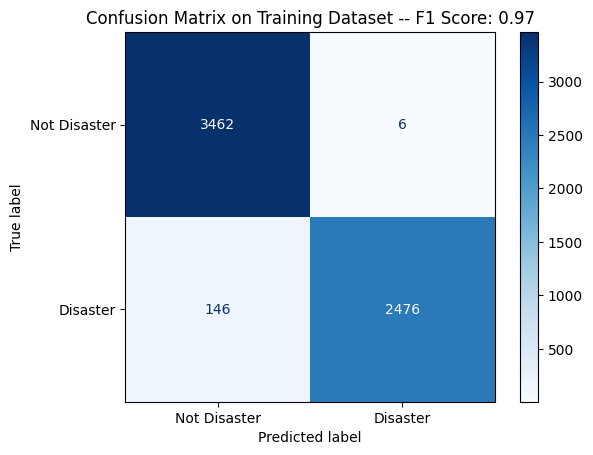

In [21]:
y_pred_train = model.predict(X_train)
displayConfusionMatrix(y_train, y_pred_train, "Training")

The GRU model has an F1 score of `0.98` on the training dataset, which we might expect to be relatively high given this dataset primarily drives model convergence.

**Precision** was also high at `0.993`, indicating low false positives. **Recall** was also relatively high at `0.966`, indicating low false negatives.

Again, this is the training set, so we expect these scores to be relatively high. However, note should be taken that these very high scores _could_ indicate overfitting on the trainig set.

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Precision: 0.7566137566137566   Recall: 0.6610169491525424


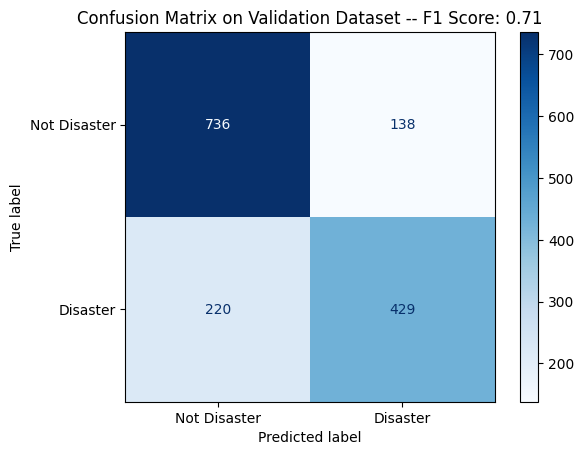

In [22]:
y_pred_val = model.predict(X_val)
displayConfusionMatrix(y_val, y_pred_val, "Validation")

The GRU model has an F1 score of `0.72` on the validation dataset, which gives us a better view of how the model _might_ perform on unseen data.

**Precision** was modest at `0.74`, which tells us that 26% of Tweets identified as indicating a disaster would not be real disasters. **Recall** was also modest at `0.70`, indicating 30% of Tweets indentified as *not* disasters would actually be disasters.

As a baseline model, the performance is mediocer with somewhat high true negatives and false positives. We want to try to do better to avoid, for example, alerting emergency services when not necessary or missing alerting emergency services for real disasters.

## GRU Model #1: Hyperparameter Tuning

We will now work through tuning hyperparameters for better results using the `GRU` model.

The [Keras RandomSearch Tuner](https://keras.io/keras_tuner/api/tuners/random/) is very useful for searching a space of potential hyperparameters that result in the best model performance. We will base model performance on validation accuracy for the hyperparameter search.

The tuner works by being provided a function to build an iteration of a model for a given set of hyperparameters as provided by the passed `HyperParameters` object. We just have to provide a list or range of hyperparameters to try for each tunable, build the model, compile it, and return it.

The tuner will run `max_trials` combinations of tunable parameters (or less if it runs out) and keeps track of the best model along with results from all trials.

We'll then call the `search()` method with the same parameters we'd normally pass to `fit()`.

In [23]:
import keras_tuner as kt

vocab_size = len(vectorizer.get_vocabulary())

def build_gru_model(hp):
    model = tf.keras.Sequential()
    model.add(vectorizer)
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=hp.Choice('embed_dim', values=[32, 64, 128]),
    ))
    model.add(tf.keras.layers.GRU(
        units=hp.Choice('gru_units', values=[32, 64, 128]),
        dropout=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1),
        recurrent_dropout=0.0,
        # recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.2, max_value=0.5, step=0.1),
    ))
    model.add(tf.keras.layers.Dense(units=hp.Choice('post_gru_dense_units',
                                                    values=[16, 32, 64]),
                                    activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[5e-3, 1e-3, 5e-4, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

tuner = kt.RandomSearch(
    build_gru_model,
    objective='val_accuracy',
    max_trials=30,  # Number of parameter combinations to try
    executions_per_trial=1,
    overwrite=True,
    directory='tuner_results',
    project_name='gru_disaster_tweets'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)



In [24]:
# %%time
tuner.search(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)


Trial 30 Complete [00h 00m 15s]
val_accuracy: 0.8082731366157532

Best val_accuracy So Far: 0.8115561604499817
Total elapsed time: 00h 05m 56s


In [25]:
# Hyperparameters for best model results based on validation accuracy.
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n\nBest Hyperparameters:")
print(f"Embedding Dim: {best_hp.get('embed_dim')}")
print(f"GRU Units: {best_hp.get('gru_units')}")
print(f"Dropout: {best_hp.get('dropout')}")
# print(f"Recurrent Dropout: {best_hp.get('recurrent_dropout')}")
print(f"Dense Units: {best_hp.get('post_gru_dense_units')}")
print(f"Learning Rate: {best_hp.get('learning_rate')}")

best_model = tuner.get_best_models(num_models=1)[0]



Best Hyperparameters:
Embedding Dim: 64
GRU Units: 64
Dropout: 0.30000000000000004
Dense Units: 64
Learning Rate: 0.0005


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [26]:
tuner.results_summary()

Results summary
Results in tuner_results/gru_disaster_tweets
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 17 summary
Hyperparameters:
embed_dim: 64
gru_units: 64
dropout: 0.30000000000000004
post_gru_dense_units: 64
learning_rate: 0.0005
Score: 0.8115561604499817

Trial 01 summary
Hyperparameters:
embed_dim: 32
gru_units: 64
dropout: 0.4
post_gru_dense_units: 16
learning_rate: 0.001
Score: 0.8082731366157532

Trial 29 summary
Hyperparameters:
embed_dim: 32
gru_units: 64
dropout: 0.2
post_gru_dense_units: 32
learning_rate: 0.0005
Score: 0.8082731366157532

Trial 12 summary
Hyperparameters:
embed_dim: 32
gru_units: 128
dropout: 0.30000000000000004
post_gru_dense_units: 32
learning_rate: 0.001
Score: 0.8076165318489075

Trial 23 summary
Hyperparameters:
embed_dim: 64
gru_units: 128
dropout: 0.2
post_gru_dense_units: 64
learning_rate: 0.0005
Score: 0.8056467771530151

Trial 08 summary
Hyperparameters:
embed_dim: 32
gru_units: 32
dropout: 0.30000000000000004

In [27]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 35)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 35, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,185 (2.55 MB)

 Trainable params: 669,185 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
best_model.save('/kaggle/working/tuner_results/gru_disaster_tweets/best_model.keras')

In [29]:
# pred_probs = best_model.predict(test_df["text"].values)
# pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

# # Prepare submission
# submission_df = pd.DataFrame({
#     "id": test_df["id"],
#     "target": pred_labels
# })

# # Write to CSV (uncomment only for "best" GRU model eval)
# submission_df.to_csv("submission.csv", index=False)

## GRU Model #1: Tuned Results

The Keras tuner found the following hyperparameters:

```
embed_dim: 64
gru_units: 64
dropout: 0.30
post_gru_dense_units: 64
learning_rate: 0.0005
Score: 0.8089297413825989
```

Upon submission to the Kaggle competition, the **tuned** GRU model scored 0.79007 as the F1 score.

As with the original GRU model, we can further look at confusion matrices and F1 scores for the training and validation sets to extract more information about the performance of the model.

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Precision: 0.9432624113475178   Recall: 0.7608695652173914


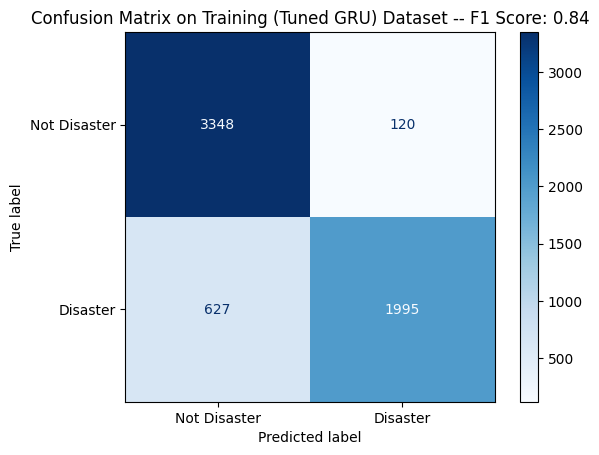

In [30]:
y_pred_train_best = best_model.predict(X_train)
displayConfusionMatrix(y_train, y_pred_train_best, "Training (Tuned GRU)")

Training results for the tuned GRU model gave us:
* Precision: 0.942
* Recall: 0.758

The slightly lower values here combined with the better F1 score indicate we're on a good track, and the model is likely better performing and more generalized, and has less overfitting.

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Precision: 0.8554455445544554   Recall: 0.6656394453004623


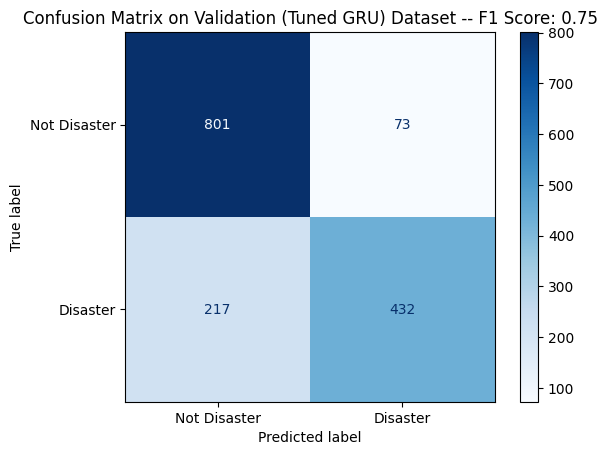

In [31]:
y_pred_val_best = best_model.predict(X_val)
displayConfusionMatrix(y_val, y_pred_val_best, "Validation (Tuned GRU)")

Validation results for the tuned GRU model gave us:
* Precision: 0.851
* Recall: 0.669

The F1 score for the validation set is 0.75. We can see that, overall, the hyperparameter tuning has reduced overfitting and resulted in a better Kaggle submission score.

## Pre-Trained BERT Model

Finally, we'll try a pre-trained [BERT](https://www.kaggle.com/models/keras/bert/keras/bert_small_en_uncased) model for comparison to our previous results.

BERT (Bidirectional Encoder Representations from Transformers) is the most complex model architecture we'll explore for this project. It primarily consists of the encoder side of a Transformer, which provides superior context awareness. Importantly, pre-trained BERT models have already been trained on millions of words from multiple sources, so should be able to derive "meaning" of short sentences (Tweets) more easily. Additionally, at each timestep, the "attention" mechanism enables consideration of the current word combined with all other past/future words in the input.

Keras provides both preprocessing and encoder layers in the model, so we're able to basically go straight to training (fine-tuning). We'll uses the smallest (2-layer) model.

In [32]:
import keras_hub

bert_classifier = keras_hub.models.BertTextClassifier.from_preset('bert_tiny_en_uncased', num_classes=2)

In [33]:
bert_classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"])

In [34]:
# Need list input formats, so rebuild (X|y)_(train|val)
X = train_df['text'].tolist()
y = train_df['target'].tolist()
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [35]:
#%%time

history = bert_classifier.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=1,
    batch_size=32,
)

I0000 00:00:1755092431.626831      57 service.cc:148] XLA service 0x7a432a4ae070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755092431.627663      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5364 - loss: 0.6772

I0000 00:00:1755092439.005466      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/191 ━━━━━━━━━━━━━━━━━━━━ 34s 86ms/step - accuracy: 0.7143 - loss: 0.5591 - val_accuracy: 0.7945 - val_loss: 0.4763


In [36]:
bert_classifier.summary()

Preprocessor: "bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 128), (None,      │       4,385,920 │ padding_mask[0][0],        │
│                               │ None, 128)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 128)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │             258 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 13,158,536 (50.20 MB)

 Trainable params: 4,386,178 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,772,358 (33.46 MB)

In [37]:
pred_probs = bert_classifier.predict(test_df['text'].tolist(), batch_size=32)
pred_labels = np.argmax(pred_probs, axis=-1)

# Prepare submission
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "target": pred_labels
})

# Write to CSV (uncomment only for pre-trained BERT)
submission_df.to_csv("submission.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


## Pre-Trained BERT Model: Results


191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Precision: 0.8810592459605027   Recall: 0.7486651411136537


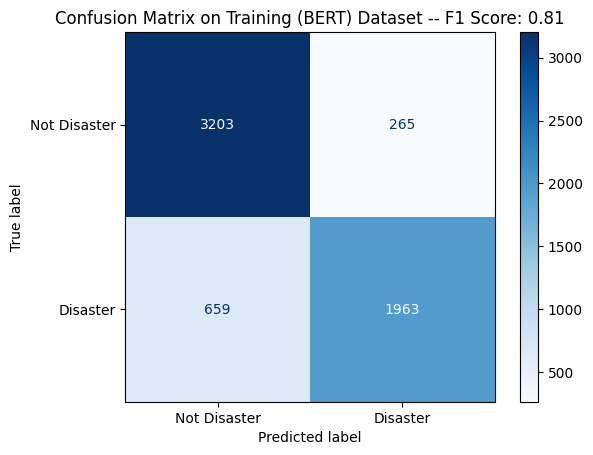

In [38]:
y_pred_train_bert = bert_classifier.predict(X_train, batch_size=32)
y_pred_train_bert_am = np.argmax(y_pred_train_bert, axis=-1)
displayConfusionMatrix(y_train, y_pred_train_bert_am, "Training (BERT)")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Precision: 0.795774647887324   Recall: 0.6964560862865947


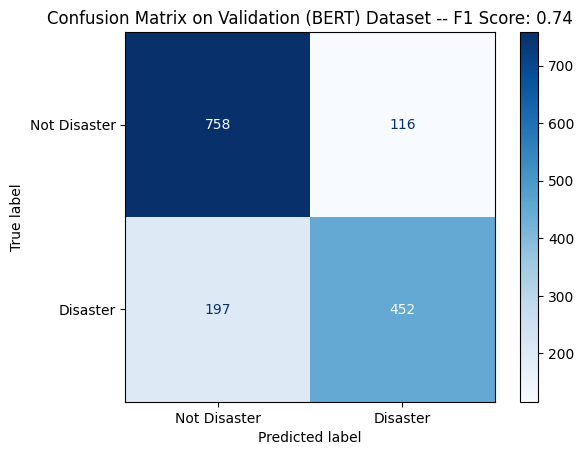

In [39]:
y_pred_val_bert = bert_classifier.predict(X_val, batch_size=32)
y_pred_val_bert_am = np.argmax(y_pred_val_bert, axis=-1)
displayConfusionMatrix(y_val, y_pred_val_bert_am, "Validation (BERT)")

Training results for the BERT model gave us:
* Precision: 0.956
* Recall: 0.831
* F1-score: 0.89

Validation results for the BERT model gave us:
* Precision: 0.772
* Recall: 0.601
* F1-score: 0.68

Kaggle submission score for pre-trained BERT: 0.79160

# Results and Analysis

We will now review the results from the various models and hyperparameter tuning trials.

## Results Summary

| Model                                   | Kaggle Score | Validation Precision | Validation Recall | Validation F1 Score | Parameters (approx.) | Training / Tuning Time |
|-----------------------------------------|--------------|----------------------|-------------------|----------|----------------------|------------------------|
| GRU with TextVectorization              | 0.76555      | **0.9929** 🥇        | **0.9661** 🥇     | **0.9793** 🥇 | ~2M                | 2 minutes       |
| Tuned GRU with TextVectorization        | 0.79007      | 0.8915               | 0.6333            | 0.7413   | ~0.7M                | 30 minutes (includes HP-tuning) |
| Pre-Trained BERT                        | **0.79160** 🥇| 0.7723               | 0.6009            | 0.6800   | ~13M                | 30 minutes (1 epoch) |



**Baseline GRU**
The baseline GRU with TextVectorization proved to be the most efficient and robust model on the validation set. It trained in just five minutes and had a relatively small parameter count (~2 million), making it easy to train and deploy. It achieved the highest validation precision, recall, and F1 score, suggesting it generalized well to the validation data. However, its lower Kaggle score (0.76555) compared to the other models may indicate that it overfit the validation data or performed less effectively on the unseen test data.

**Tuned GRU**
The tuned GRU showed a significant improvement in performance on the unseen test data, achieving a Kaggle score of 0.79007. This was a notable increase from the baseline model, but it came at the cost of slightly lower validation recall and F1 scores. The hyperparameter tuning process extended the training time to about 30 minutes, but the model remained lightweight and fast to run. This model is ideal for situations where leaderboard ranking is the primary objective. Additionally, after identifying the best hyperparameters, future iterations could focus on further training and fine-tuning based on the "best" hyperparameters.

**Pre-trained BERT**
The pre-trained BERT model delivered the highest overall Kaggle score of 0.79160, leveraging its  pretraining to understand complex language patterns. However, it had lower validation precision, recall, and F1 scores than both GRU models, which could be due to insufficient fine-tuning or a domain mismatch between its pretraining data and the task. Due to time constraints, we tuned the BERT model with only 1-2 epochs. At approximately 13 million parameters and a 30-minute fine-tuning time, it is significantly more resource-intensive, which could pose a challenge for deployment in environments with limited compute resources.

# Conclusion

In summary, the GRU models are highly efficient and competitive, offering a strong balance of performance and resource usage. The pre-trained BERT model, while achieving the best Kaggle score, requires significantly more compute power and shows mixed results on the validation set.

Ultimately, the choice between these models depends on priorities: efficiency and generalization (baseline GRU), competition-oriented tuning (tuned GRU), or maximum leaderboard performance with heavier compute demands (BERT).

Future work (given more time) could focus on the following:
* Additional hyperparameter search combined with additional training on the "best" model from the hyperparameter search.
* More experimentation with pre-trained text-classification models (longer training, parameter tuning).
* Additional feature augmentation (e.g., extract and include hashtag values as separate features).

# References

* https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial
* https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
* https://keras.io/keras_hub/getting_started/
* https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets
* https://medium.com/@prudhviraju.srivatsavaya/lstm-vs-gru-c1209b8ecb5a
* https://keras.io/keras_tuner/
* https://keras.io/keras_tuner/getting_started/
* https://keras.io/keras_tuner/api/tuners/random/
* https://www.kaggle.com/models/keras/distil_bert